In [57]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

# Girvan-newman algorithm implementation

In [107]:
def girvan_newman(G, num_communities):
    G1 = G.copy()
    def most_valuable_edge(G0):
        if len(G0) == 1:
            return list(G0.edges())[0]
        edge_betweenness = nx.edge_betweenness_centrality(G0)
        sorted_edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
        return sorted_edge_betweenness[0][0]

    communities = list(nx.connected_components(G1))
    while (num_communities is None and len(communities) == 1) or (num_communities is not None and len(communities) < num_communities):
        edge_to_remove = most_valuable_edge(G1)
        G1.remove_edge(*edge_to_remove)
        communities = list(nx.connected_components(G1))
    return communities

In [92]:
import csv

def create_csv(communities, output_file):
    with open(f'{output_file}', 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Node', 'Cluster'])
        
        # Flatten the list of communities and sort by node ID
        nodes = sorted([(node, i + 1) for i, community_set in enumerate(communities) for node in community_set], key=lambda x: x[0])
        
        for node, cluster in nodes:
            csv_writer.writerow([node, cluster])
    

# Function for drawing community graph

In [90]:
def draw_communities(G, detected_communities):
    num_communities = len(detected_communities)
    colors = plt.cm.tab10(np.linspace(0, 1, num_communities))
    pos = nx.spring_layout(G)

    # Draw nodes with labels
    node_labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    for i, community_set in enumerate(detected_communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community_set), node_color=[colors[i]] * len(community_set), label=f"Community {i + 1}")

    nx.draw_networkx_edges(G, pos)
    plt.legend()
    plt.show()


# Get colormap for communities

In [69]:
def get_node_colors(G, detected_communities):
    num_communities = len(detected_communities)
    community_colors =  plt.cm.tab10(np.linspace(0, 1, num_communities))
    node_community_mapping = {}
    for i, community_set in enumerate(detected_communities):
        for node in community_set:
            node_community_mapping[node] = i
    node_colors = [community_colors[node_community_mapping[node]] for node in G.nodes()]
    return node_colors

### Test of general correctness of algorithm (on customized community graphs, with high `p_within` between communities, and low `p_between` between communities) 

In [67]:
def get_community_graph(N=20, num_communities=4, p_within=0.4, p_between=0.05):
    
    G = nx.Graph()

    # intra-community edges
    node_community_mapping = {}
    for i in range(num_communities):
        nodes = range(i * N, (i + 1) * N)
        G.add_nodes_from(nodes)
        node_community_mapping.update({node: i for node in nodes})
        for u in nodes:
            for v in nodes:
                if u != v and random.random() < p_within:
                    G.add_edge(u, v)
                    G[u][v]['width'] = 0.6

    # inter-community edges
    for i in range(num_communities):
        for j in range(i + 1, num_communities):
            for u in range(i * N, (i + 1) * N):
                for v in range(j * N, (j + 1) * N):
                    if random.random() < p_between:
                        G.add_edge(u, v)
                        G[u][v]['width'] = 0.3

    community_colors =  plt.cm.tab10(np.linspace(0, 1, num_communities))

    node_colors = [community_colors[node_community_mapping[node]] for node in G.nodes()]

    # Draw the graph with community colors
    pos = nx.spring_layout(G)
    width = [G[u][v]['width'] for u, v in G.edges()]
    clustering_coefficient = nx.average_clustering(G)

    return G, pos, node_colors, width, clustering_coefficient

### Wider (darker) edges correspond to edges within communities. 

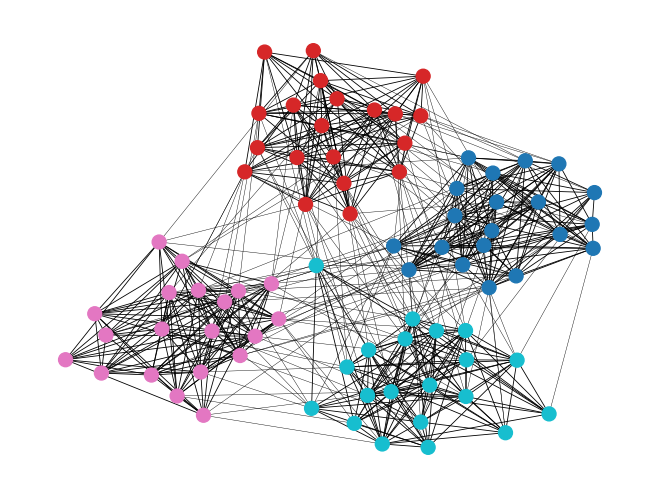

In [70]:
G, pos, node_colors, width, clustering_coefficient = get_community_graph()
num_communities = 4
detected_communities = girvan_newman(G, num_communities)
node_colors = get_node_colors(G, detected_communities)
nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, width=width)

### Slightly harder task (lower `p_within`, higher `p_between`)


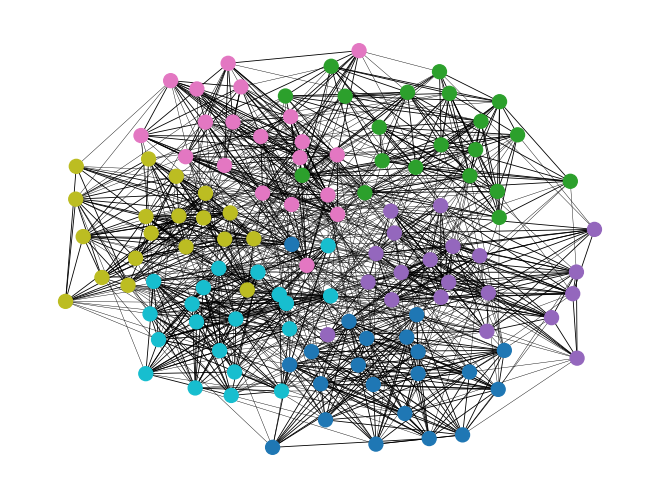

In [74]:
G, pos, node_colors, width, clustering_coefficient = get_community_graph(num_communities=6, p_within=0.35, p_between=0.08)
num_communities = 6
detected_communities = girvan_newman(G, num_communities)
node_colors = get_node_colors(G, detected_communities)
nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors, width=width)

# Competition

In [46]:
import csv
import networkx as nx

def load_graph_from_csv(filename):
    with open(filename, "r") as f:
        reader = csv.reader(f)
        data = list(reader)

    # Check if matrix is symmetric
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            if data[i][j] != data[j][i]:
                raise ValueError("Matrix is not symmetric.")

    # Create graph
    n = len(data)
    G = nx.Graph()

    for i in range(n):
        for j in range(i + 1, n):
            if data[i][j] == "1":
                G.add_edge(i, j)

    return G

In [105]:
import time

# D1-K=2

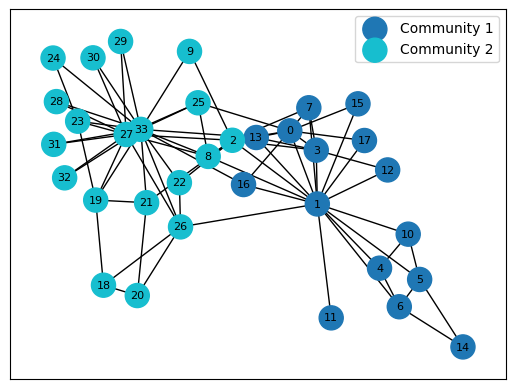

0.05866837501525879


In [108]:
G1 = load_graph_from_csv("data/D1-K=2.csv")
start_time = time.time()
detected_communities = girvan_newman(G1, 2)
end_time = time.time()
draw_communities(G1, detected_communities)
create_csv(detected_communities, "results/D1-K=2.csv")
execution_time = end_time - start_time
print(execution_time)

# D1-UNC

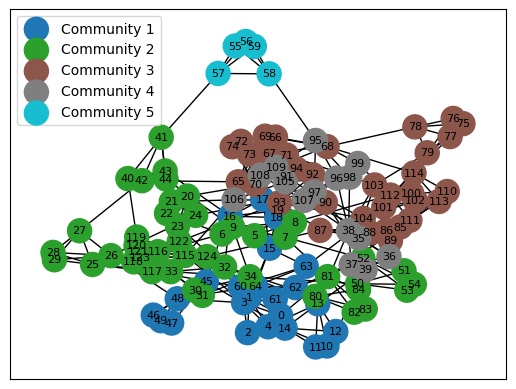

1.6334452629089355


In [114]:
G1_UNC = load_graph_from_csv("data/D1-UNC.csv")
start_time = time.time()
detected_communities = girvan_newman(G1_UNC, 5)
end_time = time.time()
draw_communities(G1_UNC, detected_communities)
create_csv(detected_communities, "results/D1-UNC.csv")
execution_time = end_time - start_time
print(execution_time)

# D2-K=7

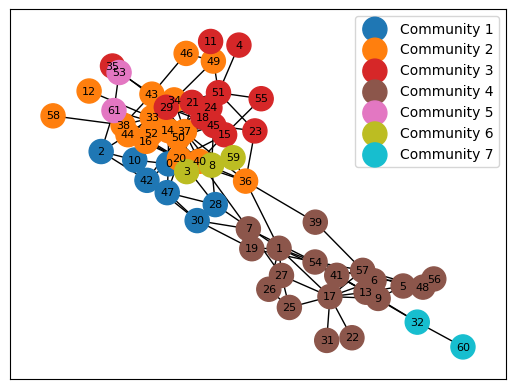

0.4091484546661377


In [119]:
G2 = load_graph_from_csv("data/D2-K=7.csv")
start_time = time.time()
detected_communities = girvan_newman(G2, 7)
end_time = time.time()
draw_communities(G2, detected_communities)
create_csv(detected_communities, "results/D2-K=7.csv")
execution_time = end_time - start_time
print(execution_time)

# D2-UNC

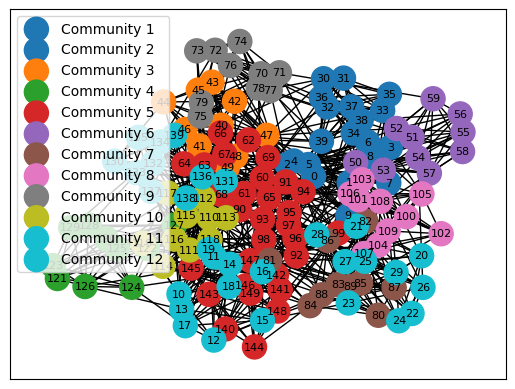

20.23660397529602


In [116]:
G2_UNC = load_graph_from_csv("data/D2-UNC.csv")
start_time = time.time()
detected_communities = girvan_newman(G2_UNC, 12)
end_time = time.time()
draw_communities(G2_UNC, detected_communities)
create_csv(detected_communities, "results/D2-UNC.csv")
execution_time = end_time - start_time
print(execution_time)

# D3-K=12

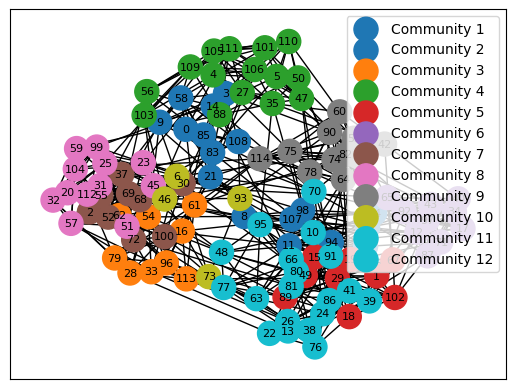

6.957764387130737


In [118]:
G3 = load_graph_from_csv("data/D3-K=12.csv")
start_time = time.time()
detected_communities = girvan_newman(G3, 12)
end_time = time.time()
draw_communities(G3, detected_communities)
create_csv(detected_communities, "results/D3-K=12.csv")
execution_time = end_time - start_time
print(execution_time)

# D3-UNC

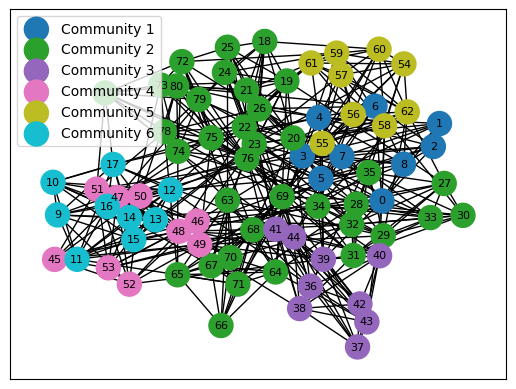

2.6960713863372803


In [117]:
G3_UNC = load_graph_from_csv("data/D3-UNC.csv")
start_time = time.time()
detected_communities = girvan_newman(G3_UNC, 6)
end_time = time.time()
draw_communities(G3_UNC, detected_communities)
create_csv(detected_communities, "results/D3-UNC.csv")
execution_time = end_time - start_time
print(execution_time)